This notebook fits the diffraction geometry + module geometry to a series of powder patterns (with different beam centers)

In [1]:
import time
start = time.time()
import pylab as pl, numpy as np, os
from glob import glob
from ImageD11 import transform
from ImageD11.transformer import transformer
from ImageD11.parameters import read_par_file
from ImageD11.columnfile import columnfile
import h5py
from scipy.optimize import curve_fit
import fabio
%matplotlib inline

In [6]:
direc =r'C:\Users\kenneth1a\Documents\beamlineData\moduleDistortion\images/'
os.chdir(direc)
fltdir = 'pilatusSpatial'
files = glob(f'{fltdir}/*.par')
flts = [file.replace('.par','.flt') for file in files]
cbfs = glob('*.cbf')
print(cbfs)

# The par files need to be manually created ... ?
#  ... done in ImageD11_gui.py
#
# ... then all iterated using fitted parameters as a starting point
for file in files:
    # initial 
    p = read_par_file(file)
#    p = read_par_file("eigerSpatial/%ds.par"%(i)) # s = spatial
    print(file,p.get('y_center'),p.get('z_center'),p.get('distance'))
a0 = p.get('cell__a')
w = p.get('wavelength') #takes wavelength from par file
print(a0,w)

12.39842/w #approximate energy

['pos01_Si_dty_179_dtz_17_000_0001p.cbf', 'pos02_Si_dty_179_dtz_53.5_000_0001p.cbf', 'pos03_Si_dty_179_dtz_90_000_0001p.cbf', 'pos04_Si_dty_179_dtz_126.4_000_0001p.cbf', 'pos08_Si_dty_222_dtz_126.4_000_0001p.cbf', 'pos12_Si_dty_265_dtz_126.4_000_0001p.cbf', 'pos16_Si_dty_308_dtz_126.4_000_0001p.cbf', 'pos17_Si_dty_351_dtz_17_000_0001p.cbf', 'pos18_Si_dty_351_dtz_53.5_000_0001p.cbf', 'pos19_Si_dty_351_dtz_90_000_0001p.cbf', 'pos20_Si_dty_351_dtz_126.4_000_0001p.cbf']
pilatusSpatial\pos01_Si_dty_179_dtz_17_000_0001p.par 250.2394799070778 1049.9948055976192 1161.4673405671483
pilatusSpatial\pos02_Si_dty_179_dtz_53.5_000_0001p.par 250.04938637686217 1262.1442467774164 1161.8170538310874
pilatusSpatial\pos03_Si_dty_179_dtz_90_000_0001p.par 249.74363882251015 1474.0635044653372 1162.0629464297417
pilatusSpatial\pos04_Si_dty_179_dtz_126.4_000_0001p.par 249.80343431962356 1685.511171349769 1161.935783927318
pilatusSpatial\pos08_Si_dty_222_dtz_126.4_000_0001p.par 499.5027091541386 1686.00957089

48.60410051354424

In [7]:
cbf = fabio.open(cbfs[0]).data #make this an array of an image from your detector

#this cbfhead section may need to be changed if you have a different header format
#just to extract pixel sizes, which you probably already know anyway,
#then just set pixy and pixz to those values manually


#cbfhead = fabio.open(cbfs[0]).header
#cbfdata = cbfhead["_array_data.header_contents"].replace('\r','').split('\n')
#for item in cbfdata:
#    if 'Pixel_size' in item:
#        pixy = round(float(item.split(' ')[2])*1000,3) #x 1000 to convert to mm
#        pixz = round(float(item.split(' ')[5])*1000,3)
#        break
######
pixy = 0.172 #input your values here
pixz = 0.172
    
y,x = np.where(cbf < 0) #change this condition if gaps are defined differently
cbfysize = len(cbf)
cbfxsize = len(cbf[0])
print(f'xsize = {cbfxsize}, ysize = {cbfysize}')


xgaps = []
ygaps = []


for i in set(x):
    if len(np.where(x==i)[0]) == cbfysize:
        xgaps.append(i)
for i in set(y):
    if len(np.where(y==i)[0]) == cbfxsize:
        ygaps.append(i)



xgapedge = []
ygapedge = []

lengapx = 0
lengapy = 0

xgapfound = False
ygapfound = False



fo = [0]
so = [0]
gapno = 0



for i in range(len(xgaps[1:])+1):
    lengapx += 1
    if xgaps[i] != xgaps[i-1] + 1:
        xgapedge.append(xgaps[i])
        
        gapno += 1
        fo.append(lengapx)
    elif xgaps[i] == xgaps[i-1]+1: 
        fo[gapno] += 1

gapno = 0

for i in range(len(ygaps[1:])+1):
    lengapy += 1
    if ygaps[i] != ygaps[i-1] + 1:
        ygapedge.append(ygaps[i])
        gapno += 1
        so.append(lengapy)
    elif ygaps[i] == ygaps[i-1]+1:
        so[gapno] += 1
print(f'x gap edges = {xgapedge}, y gap edges = {ygapedge}')






#print(lengapx,lengapy)
noxmodules = len(xgapedge) + 1
noymodules = len(ygapedge) + 1
no_modules = noxmodules*noymodules
print(f'no. modules = {noxmodules}x{noymodules} = {no_modules} total')

fs = xgaps[0]
ss = ygaps[0]
print(f'module size = {fs}x{ss}')


fo = np.array(fo)
so = np.array(so)
ygapsizes = [so[i]-so[i-1] for i in range(1,len(so))]
xgapsizes = [fo[i]-fo[i-1] for i in range(1,len(fo))]


print(f'slow offsets = {so}, fast offsets = {fo}')

noChipsx = 8 #change these for different chip layouts. Pilatus 2m Si appears to be 8x2
noChipsy = 2 #for Pilatus 2m CdTe it is 4x2 as modules divided into 2 submodules with 1 pixel gap in between

virtualLinesx = []
virtualLinesy = []


for l in range(len(fo)):
    for i in range(1,noChipsx):
        virtualLinePosx = i*(fs-1)//noChipsx
        virtualLinesx.append(fs*l + fo[l] + virtualLinePosx)
for l in range(len(so)):
    for i in range(1,noChipsy):
        virtualLinePosy = i*(ss-1)//noChipsy
        virtualLinesy.append(ss*l + so[l] + virtualLinePosy)
print(f'virtual lines x = {virtualLinesx}')
print(f'virtual lines y = {virtualLinesy}')

xsize = 1475, ysize = 1679
x gap edges = [243, 487, 737, 981, 1231], y gap edges = [195, 407, 619, 831, 1043, 1255, 1467]
no. modules = 6x8 = 48 total
module size = 243x195
slow offsets = [  0  17  34  51  68  85 102 119], fast offsets = [ 0  1  8  9 16 17]
virtual lines x = [30, 60, 90, 121, 151, 181, 211, 274, 304, 334, 365, 395, 425, 455, 524, 554, 584, 615, 645, 675, 705, 768, 798, 828, 859, 889, 919, 949, 1018, 1048, 1078, 1109, 1139, 1169, 1199, 1262, 1292, 1322, 1353, 1383, 1413, 1443]
virtual lines y = [97, 309, 521, 733, 945, 1157, 1369, 1581]


In [8]:
frms = np.arange(1,len(files)+1,dtype = np.uint8)#[1,2,3,4]

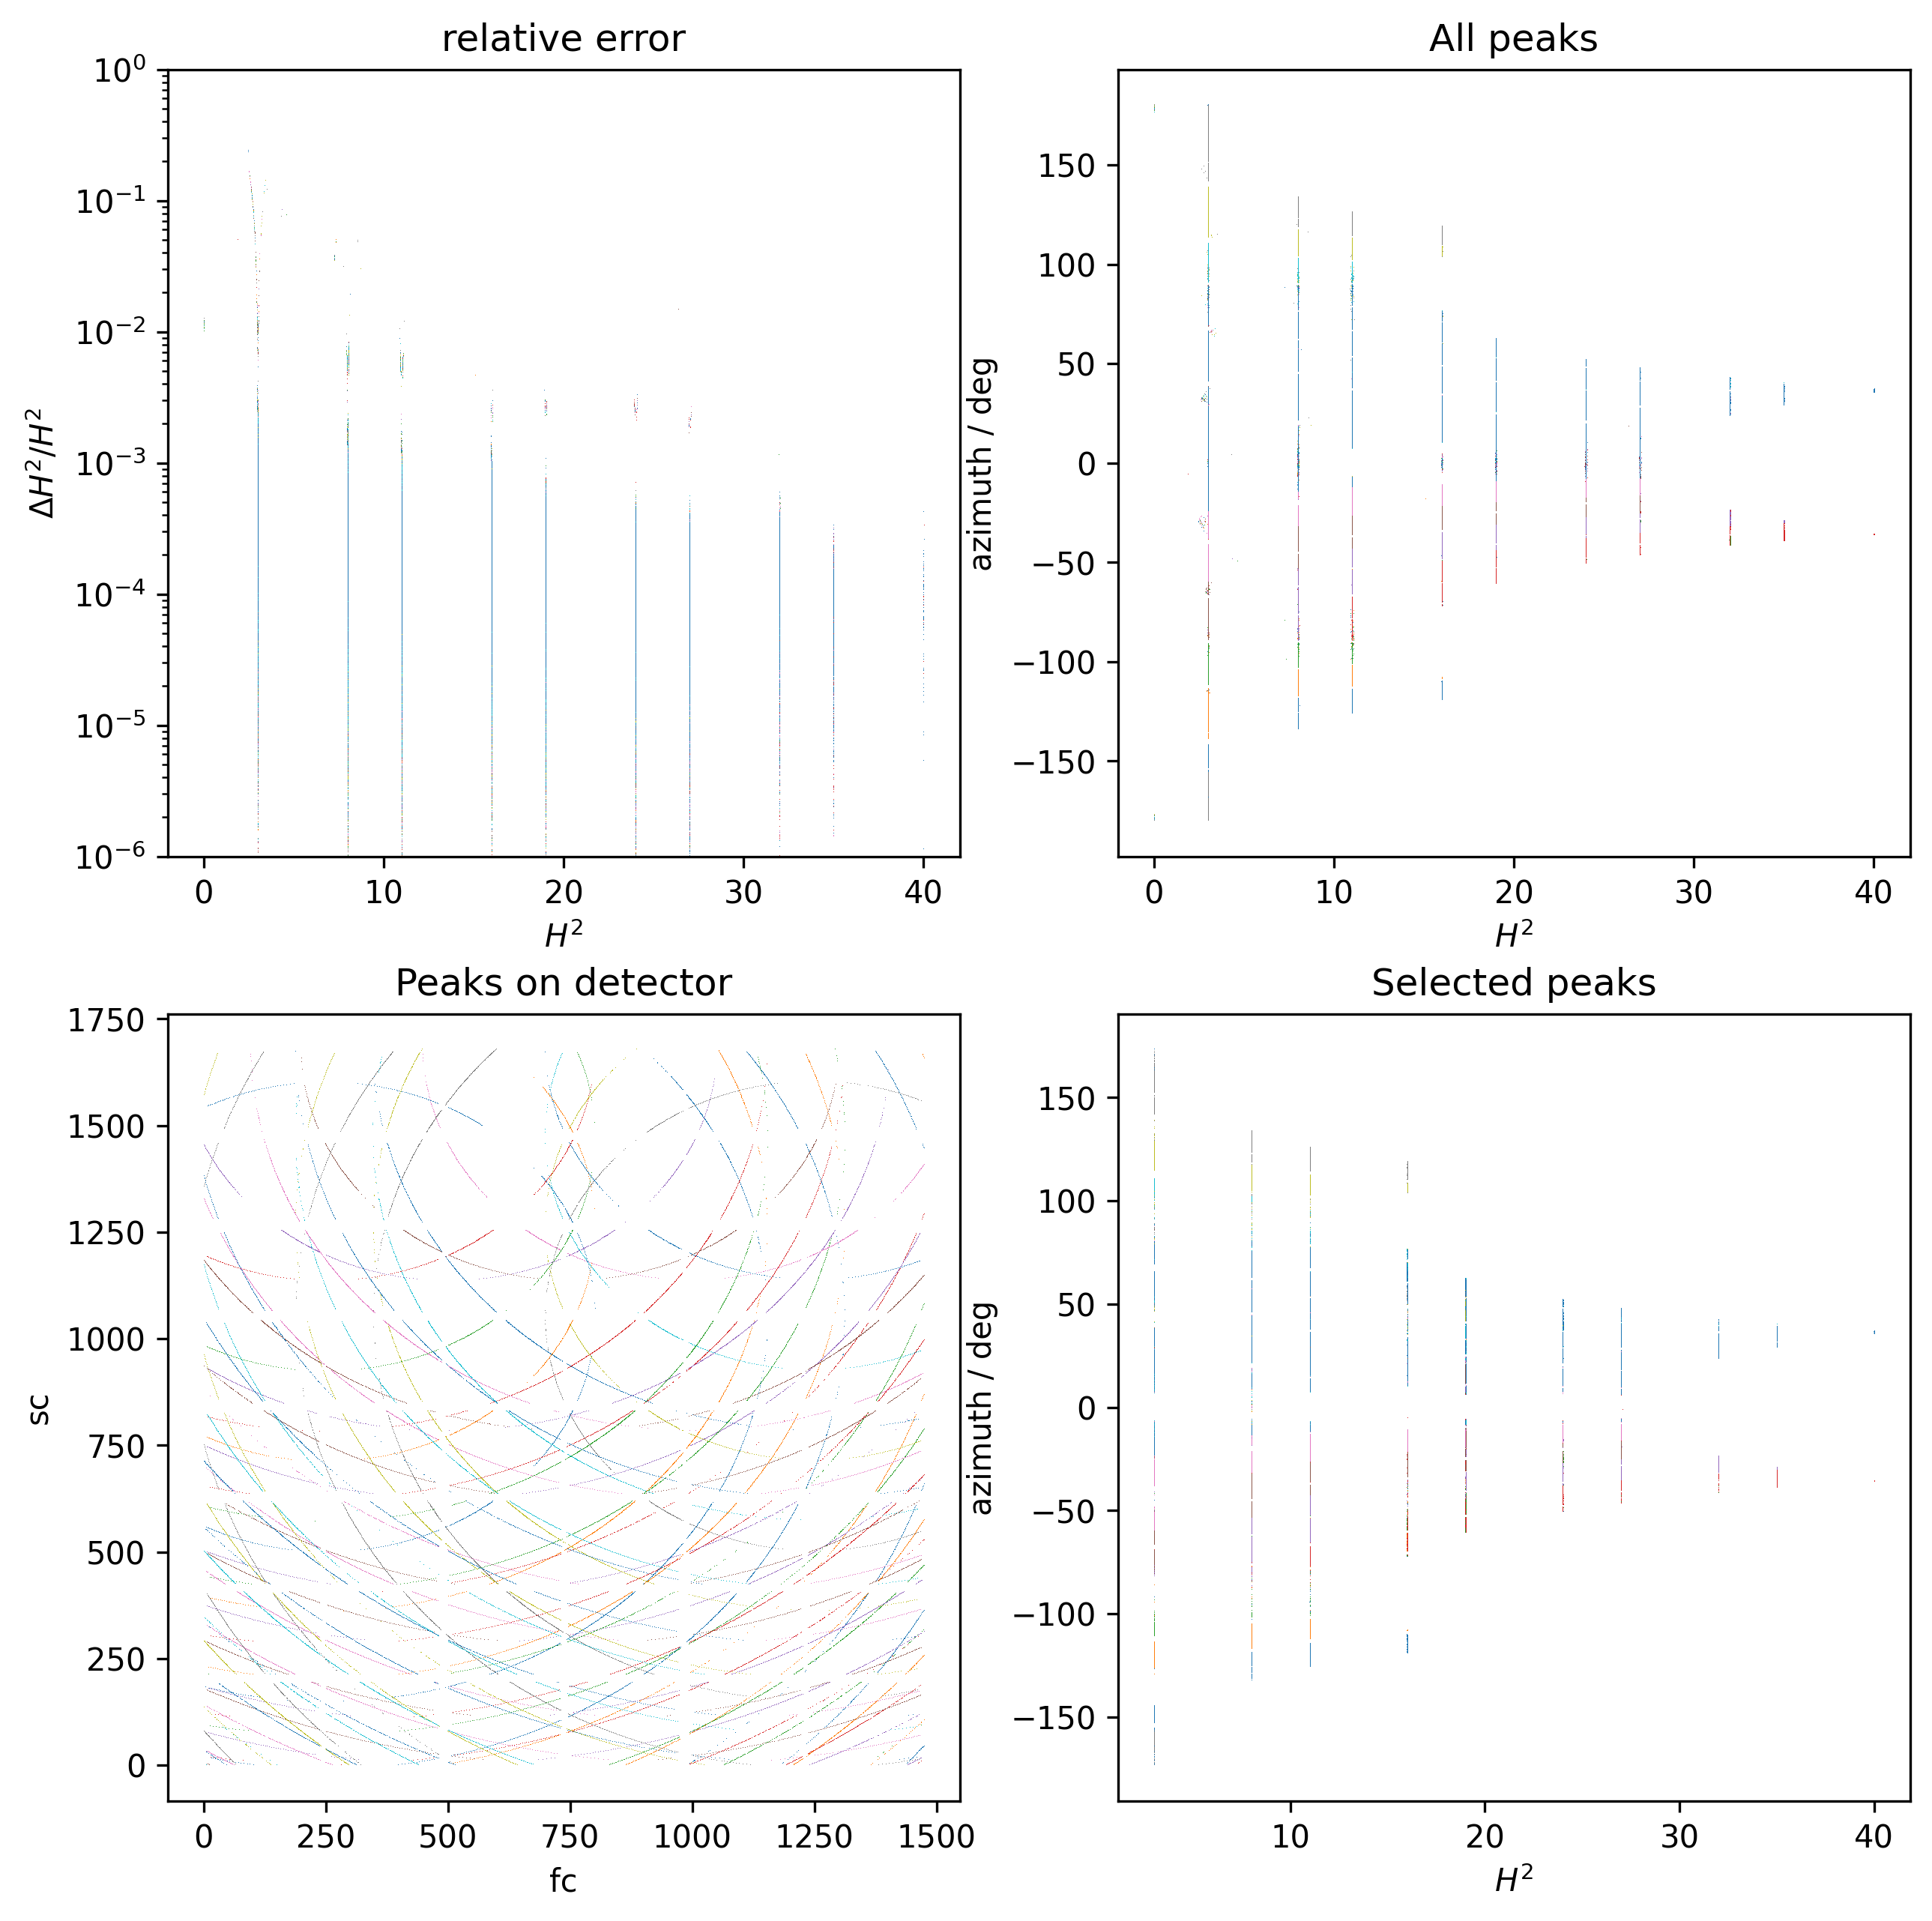

In [9]:
# created via moduleSpatialPeakSearch
f, ((a3, a4),(a1,a2)) = pl.subplots(2,2,figsize=(10,10),dpi = 300)
cf = {}

ds0 = a0*a0
for i,file in enumerate(files,1):
    ds0 = a0*a0
    # Load the peaks and parameters:
    basename = os.path.splitext(file)[0]
    basenamesub = basename.replace('_s','')
    fltfile = f'{basenamesub}.flt'
    c = columnfile(fltfile)
    c.parameters.loadparameters(file)
    c.updateGeometry()
    # Create column of frame number
    c.addcolumn(np.ones(c.nrows)*i,'frame')
    # (d*_obs)^2 / (a_0)^2 from cubic hkl to d-spacing formula
    c.addcolumn(np.ones(c.nrows)*c.ds**2*ds0,'hkl2')
    # nearest integers == fit target values
    c.addcolumn(np.round(c.hkl2),'ihkl2')
    # something like a strain
    se = abs( c.ihkl2 - c.hkl2 )/np.where( c.ihkl2 > 0, c.ihkl2, 1)
    etareplot = np.where(c.eta < 0, c.eta + 180, c.eta - 180)
    a3.plot(c.hkl2, se, ",")
    a4.plot(c.hkl2, etareplot, ",")
    c.filter((c.Number_of_pixels>7) & (c.ihkl2>2) &  (se<2e-3) )
    etareplot = np.where(c.eta < 0, c.eta + 180, c.eta - 180)
    a1.plot(c.fc,c.sc,',')
    a2.plot(c.hkl2,etareplot,',')
    cf[i] = c
a1.set(title='Peaks on detector', ylabel='sc', xlabel='fc')
a2.set(title='Selected peaks', ylabel='azimuth / deg', xlabel='$H^2$')
a3.set(yscale='log', ylim=(1e-6,1), title='relative error', ylabel='$\Delta H^2/H^2$', xlabel='$H^2$')
_ = a4.set(title='All peaks', ylabel='azimuth / deg', xlabel='$H^2$')


In [10]:
# put together all of the peaks:
allpks = np.concatenate( [cf[f].bigarray for f in frms], axis=1)
# ... and place them into an ImageD11 colummfile object
allc = c.copy()
allc.set_bigarray(allpks)
allc.nrows, np.sum([cf[f].nrows for f in frms])


(34343, 34343)

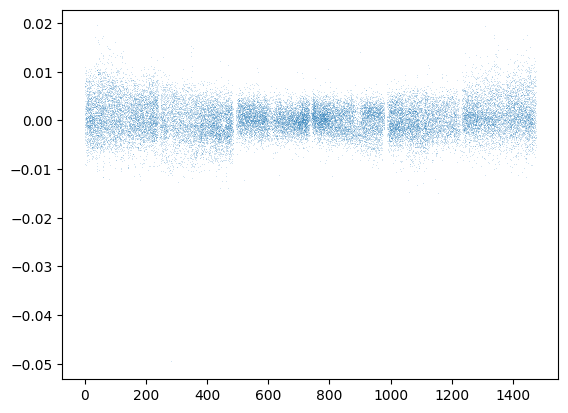

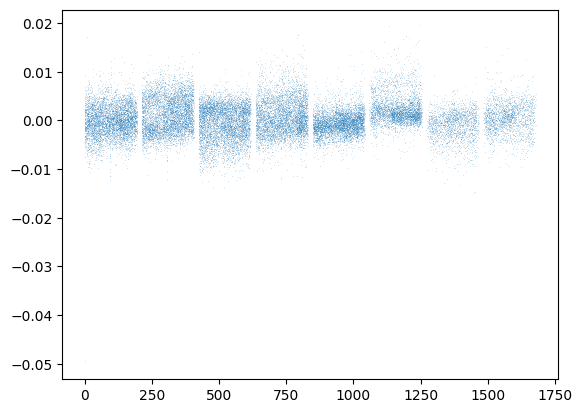

In [11]:
# Remove "bad" peaks from virtual shared pixels
#uncomment the following lines if it may be useful
#for col in virtualLinesx:
#    allc.filter(abs(allc.fc-col) > 2.1)
#for row in virtualLinesy:
#    allc.filter(abs(allc.sc-row)>2.1)
pl.figure(2)
pl.plot(allc.fc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)
pl.figure(3)
pl.plot(allc.sc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)

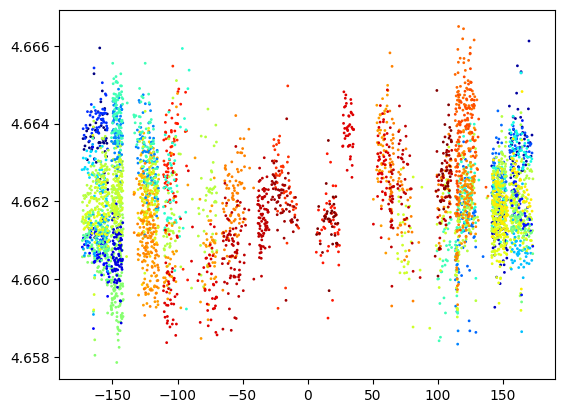

In [14]:
# just one ring, color by module
pl.figure(4)
m = allc.ihkl2 == 3
pl.scatter(allc.eta[m],allc.tth[m],c=allc.module[m], s = 1, cmap = 'jet')

In [15]:
frm = np.unique(allc.frame)
modu = np.unique(allc.module)
print(frm, modu)


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


In [16]:
# set up a fitting problem : these parameters will be fed to the calchkl2 routine below

# distance, tilts, centers for each image 
pars = [ ]
pnames = [ ]
for f in frm:
    pars.append( cf[f].parameters.get('distance') / a0 ) # distance scaled on lattice
    pnames.append( '%d:distance/a'%(f) )
    for pname in 'y_center z_center tilt_y tilt_z'.split():
        pars.append( cf[f].parameters.get(pname) )
        pnames.append( '%d:%s'%(f, pname) )

        
pars.append( a0 ) # effectively the wavelength
pnames.append( 'a0' )
framepars = len(pars)
nframes = len(cf.keys())


pars += [0. for i in range((no_modules-1)*3)] # 16 module centers and tilts, BUT LAST IS FIXED, 24 on pilatus2m
pnames += ["M[%d,%d]"%(i,j) for i in range(no_modules-1) for j in range(3) ]
for n,v in zip(pnames, pars):
    print(n,v)
# offset, rotation for each module

1:distance/a 213.85135496404072
1:y_center 250.2394799070778
1:z_center 1049.9948055976192
1:tilt_y 0.006700433457075439
1:tilt_z 0.00011055541596558259
2:distance/a 213.91574476884207
2:y_center 250.04938637686217
2:z_center 1262.1442467774164
2:tilt_y 0.006196504630746714
2:tilt_z -0.00047174692793073707
3:distance/a 213.9610189350293
3:y_center 249.74363882251015
3:z_center 1474.0635044653372
3:tilt_y 0.006895706284015312
3:tilt_z -0.00030732011727146015
4:distance/a 213.93760555740417
4:y_center 249.80343431962356
4:z_center 1685.511171349769
4:tilt_y 0.005733581496141827
4:tilt_z -0.00021576959532585492
5:distance/a 213.96585152205625
5:y_center 499.5027091541386
5:z_center 1686.0095708973765
5:tilt_y 0.006403025752886732
5:tilt_z -5.5625781851102154e-05
6:distance/a 213.96154392179298
6:y_center 749.2200352415355
6:z_center 1686.6094560806291
6:tilt_y 0.006442498308740687
6:tilt_z 0.00038797005254541394
7:distance/a 213.9530775123212
7:y_center 998.9415776255614
7:z_center 1687.3

In [17]:
#detector module sizes - 513x512 for Eiger 4M, 487x195 for Pilatus2M



def module(a,i,j,fs=fs,ss=ss,fo=fo,so=so):
    #p = padding around the outside for debug
    '''
    i and j are module indexes. 
    '''
    f = fs*j + fo[j]
    s = ss*i + so[i]
    return a[s:s+ss,f:f+fs]

def module_center( i, j,fs=fs,ss=ss,so=so,fo=fo ):

    # print(i.dtype,j.dtype,j.shape)
    return so[i] + ss*(i+0.5), fo[j] + fs*(j+0.5)

def mp_last( pmods ):
    """ Compute the parameters of the last module from the previous ones 
    We set the sum of all modules to be zero
    """
    pallmods = np.array(list(pmods) + [0,0,0]).reshape( int(len(pmods)/3)+1, 3) 
    pallmods[-1,:] = -np.sum(pallmods, axis=0) # last module is fixed to make mean zero
    return pallmods
    
    
def do_spatial(s_raw, f_raw, m, modpars):
    """
    s_raw = co-ordinate in the slow pixel direction
    f_raw = co-ordinate in the fast pixel direction
    m = module for this peak (in the range 0,15 for Eiger4M)
    modpars = spatial parameters (offset_slow, offset_fast, angle_rad)
    """
    global noxmodules

    i = m // noxmodules
    j = m % noxmodules
    cs, cf = module_center( i, j )
    shift_s = np.array( modpars[:,0] )
    shift_f = np.array( modpars[:,1] )
    ds = s_raw[:] - cs + shift_s[m]
    df = f_raw[:] - cf + shift_f[m]
    rotates = modpars[:,2]
    sinr = np.sin(rotates)
    cosr = np.cos(rotates)
    dsr =  cosr[m] * ds  + sinr[m] * df
    dfr = -sinr[m] * ds  + cosr[m] * df
    sc = dsr + cs
    fc = dfr + cf
    return sc,fc    

def calchkl2( colf, *args ):
    """
    colf = columnfile (table) containing labelled peaks
    *args = parameters to be fitted
    """
    fpars = np.array(list(args))
    global framepars, frm, w # above
    modpars = mp_last(fpars[framepars:]) # make last module == sum of previous
    #
    ycalc = np.zeros(colf.nrows, float)
    # apply the current spatial correction
    m = colf.module[:].astype(int)
    sc, fc = do_spatial( colf.s_raw, colf.f_raw, m, modpars )
    

    e = 12.398419745832/w
    a0 = fpars[framepars-1]
    for k,rf in enumerate(frm):
        f = int(rf)
        lo = np.searchsorted( colf.frame, f )   # assume data still sorted by frame
        hi = np.searchsorted( colf.frame, f+1 )
        # compute x,y,z laboratory
        x,y,z = transform.compute_xyz_lab( (sc[lo:hi], fc[lo:hi]), 
                                               distance = fpars[k*5]*a0, # take out ds0 again
                                               y_center = fpars[k*5+1],
                                               z_center = fpars[k*5+2],
                                               y_size=pixy, z_size=pixz,
                                               tilt_y = fpars[k*5+3],
                                               tilt_z = fpars[k*5+4],
                                               tilt_x = 0,
                                               o11=1,o12=0,o21=0,o22=-1 )
        # radius:
        r = np.sqrt(y*y + z*z)
        # two theta:
        tthrad = np.arctan2(r, x)
        # wvln = 2*d*sin(th)
        # 1/d = 2*sin(th)/wvln
        # c.ds**2*ds0
        ds = 2*np.sin( tthrad/2 ) / w
        ycalc[lo:hi] = ds*ds*a0*a0
    scor = np.mean((ycalc - colf.ihkl2)**2)
    strain = (ycalc - colf.ihkl2)/colf.ihkl2  # approximately zero
    return strain

[]

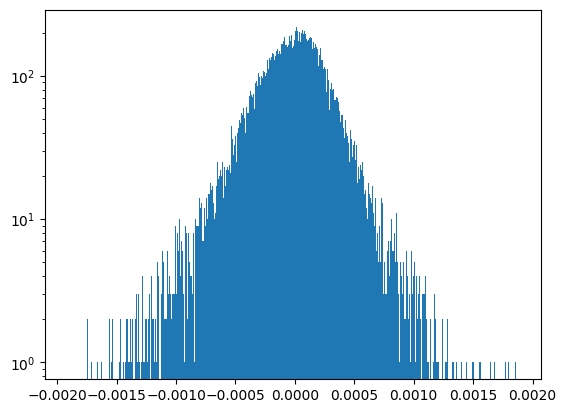

In [18]:
yc = calchkl2( allc, *pars )
pl.figure()
pl.hist(yc,bins=1024)
pl.semilogy()

In [19]:
avgi = allc.sum_intensity / allc.Number_of_pixels   # average intensity in a peak 
sigma = avgi/avgi.max()                             # relative weights

fpars, matrx = curve_fit( calchkl2,               # function to fit
                               allc,                    # 'x' argument to function 
                               np.zeros(allc.nrows),    # y_obs values (integer hkls)  
                               pars,                    # parameters to be fitted
                               sigma = sigma  )

Correlation above 80%
4:tilt_y 3:tilt_y 0.8644196869826475
5:z_center 5:distance/a 0.8322515943480343
5:tilt_y 3:tilt_y 0.8403117711974618
5:tilt_y 4:tilt_y 0.901826424016028
6:z_center 6:distance/a 0.8671554053586538
6:tilt_y 3:tilt_y 0.802895431031304
6:tilt_y 4:tilt_y 0.8704108783002027
6:tilt_y 5:tilt_y 0.8992579852850778
7:z_center 7:distance/a 0.8286895401210672
7:tilt_y 4:tilt_y 0.8525662017767491
7:tilt_y 5:tilt_y 0.8896585299159753
7:tilt_y 6:tilt_y 0.9011642062184421
9:tilt_z 8:tilt_z 0.8153942356588243
10:tilt_y 6:tilt_y 0.8040781972353692
10:tilt_y 7:tilt_y 0.837049134254452
11:tilt_y 4:tilt_y 0.8284932892086783
11:tilt_y 5:tilt_y 0.8580623594750544
11:tilt_y 6:tilt_y 0.872296994025839
11:tilt_y 7:tilt_y 0.9002456140452926
11:tilt_y 10:tilt_y 0.8650586700670516
a0 4:tilt_y -0.8452445879552565
a0 5:tilt_y -0.8408682810901242
a0 6:tilt_y -0.8347614852899468
a0 7:tilt_y -0.848465316745565
a0 11:tilt_y -0.8603466539333935
M[1,0] M[0,0] 0.8000104323286655
M[6,0] M[0,0] 0.8454793

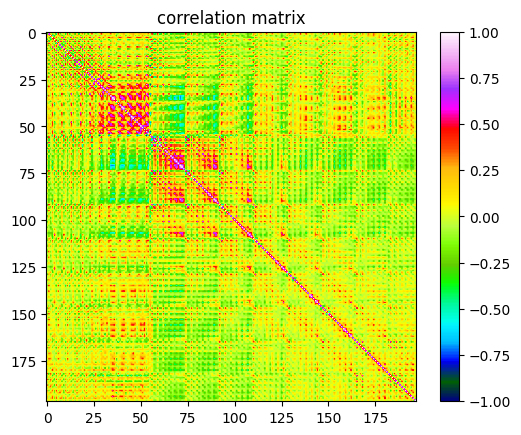

In [20]:
#print(fpars, matrx)
pl.figure()
corr = matrx.copy()
ser = np.sqrt(np.diag(corr))
corr = corr / ser 
corr = corr.T / ser
pl.imshow(corr, cmap='gist_ncar', vmin=-1)
pl.colorbar()
pl.title("correlation matrix")
print("Correlation above 80%")
for i in range(corr.shape[0]):
    for j in range(i-1):
        if abs(corr[i,j])>0.8:
            print(pnames[i],pnames[j],corr[i,j])

[]

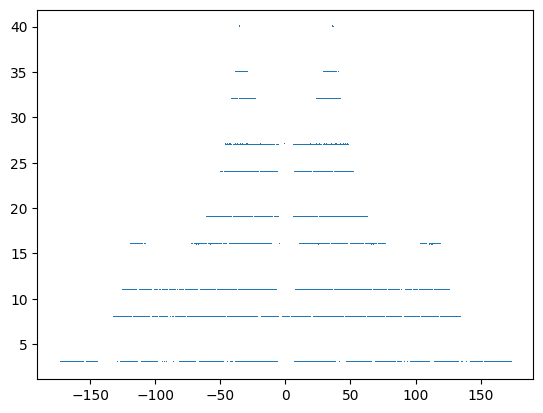

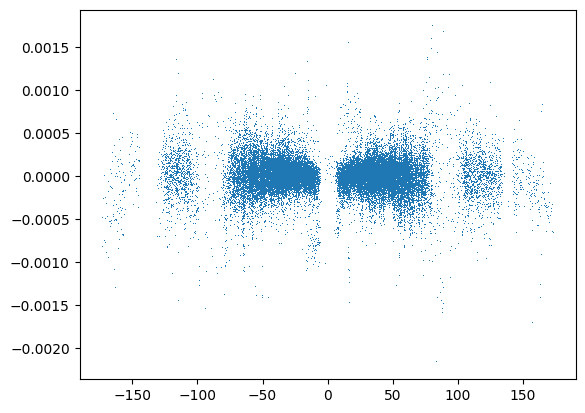

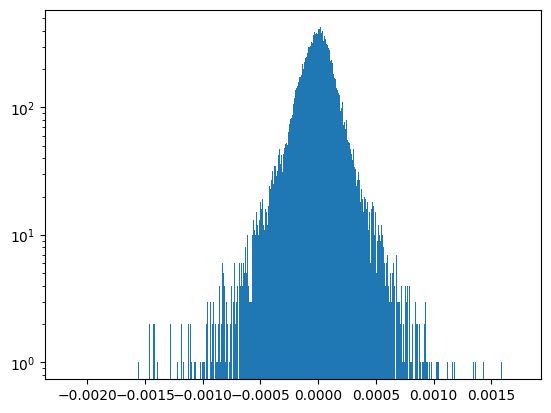

In [21]:
ycalc = calchkl2(allc, *fpars)
etareplot = np.where(allc.eta<0, allc.eta +180, allc.eta - 180)
pl.figure()
pl.plot(etareplot, ycalc*allc.ihkl2+allc.ihkl2, ",")
pl.figure()
pl.plot(etareplot, ycalc, ",")
pl.figure()
pl.hist( ycalc, bins=1024)
pl.semilogy()

In [22]:
allc.filter( abs(ycalc)<0.0003 )

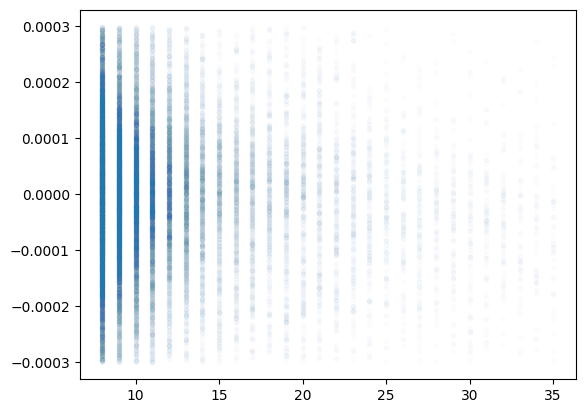

In [23]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.Number_of_pixels,ycalc,'.', alpha=0.01)

In [24]:
# repeat fitting with cleaned data
p2 = [p for p in fpars]  
fpars2, matrx2 = curve_fit( calchkl2, allc, np.zeros(allc.nrows), p2 )
p16 = mp_last(fpars2[framepars:])

In [25]:
np.savetxt("fitted_pilatus_pars2.dat",fpars2)
np.savetxt("fitted_pilatus_framepars2.dat",p16)

In [47]:
# Write spatially corrected files
a0 = fpars2[framepars-1]
rerefineDir = 'rerefine'
if not os.path.exists(f'{fltdir}/{rerefineDir}/'):
    os.mkdirs(f'{fltdir}/{rerefineDir}/')
for i,file in enumerate(files,1):
    p = read_par_file(file)
    k = i-1
    p.parameters.update( {'distance' : fpars2[k*5]*a0,
                          'y_center' : fpars2[k*5+1],
                          'z_center' : fpars2[k*5+2],
                          'tilt_y' : fpars2[k*5+3],
                          'tilt_z' : fpars2[k*5+4] } )
    p.saveparameters(file.replace('.par','_s.par').replace(fltdir,f'{fltdir}/{rerefineDir}/'))

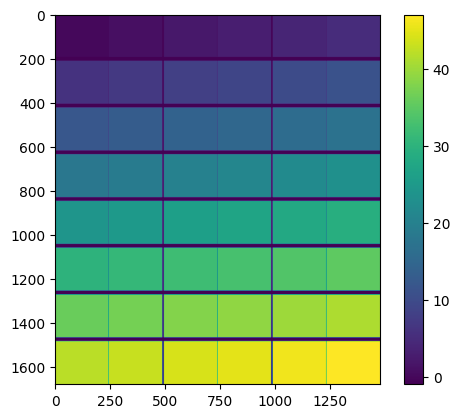

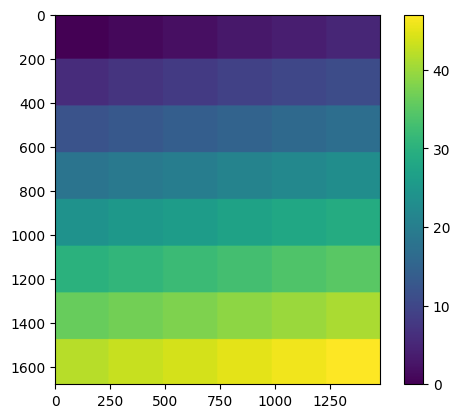

In [27]:
# Verify and create conventional distortion files
s, f = np.mgrid[0:cbfysize,0:cbfxsize]
m = np.zeros(s.shape, int)-1

for i in range(noymodules):
    for j in range(noxmodules):
        a = module(m,i,j)
        a[:,:] = i*noxmodules+j
# Make an image of which module is this pixel
pl.figure()
pl.imshow(m)
pl.colorbar()

for y,yg in zip(ygapedge,ygapsizes):
    m[y:y+yg//2,:] = m[y-1,:]
    m[y+yg//2:y+yg,:] = m[y+yg+1,:]

for x,xg in zip(xgapedge,xgapsizes):

    m[:, x:x+xg//2] = np.array([m[:, x-1]]*(xg//2)).transpose() #I was getting an error when trying to use a 1d array
    m[:, x+xg//2:x+xg] = np.array([m[:, x+xg+1]]*(xg-xg//2)).transpose()
    
    
# verify we did not mess up the real pixels:
for i in range(noymodules):
    for j in range(noxmodules):
        a = module(m,i,j)
        assert((a[:,:] == i*noxmodules+j).all())
pl.figure()
pl.imshow(m)
pl.colorbar()

In [28]:
# full image spatial:

sc,fc = do_spatial(s.ravel(),f.ravel(),m.ravel(), p16)
sc.shape=s.shape
fc.shape=f.shape
ds = sc - s      # LUT
df = fc - f      # 
print(max(df.flatten())-min(df.flatten()))
print(max(ds.flatten())-min(ds.flatten()))

0.7329173520285508
0.7539840254433443


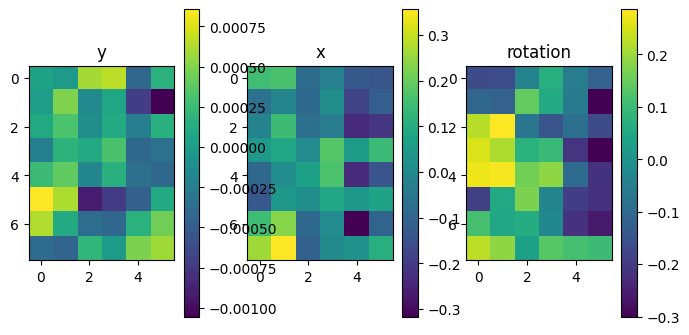

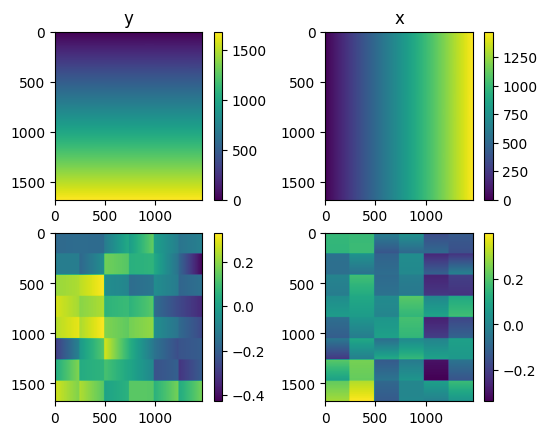

In [29]:
arrayx = np.empty(shape = (noymodules,noxmodules))
arrayy = np.empty(shape = (noymodules,noxmodules))
arrayrot = np.empty(shape = (noymodules,noxmodules))
fig,(ax1,ax2,ax3) = pl.subplots(1,3,figsize = (8,4))
for mo in range(len(p16)):
    i = mo // noxmodules
    j = mo % noxmodules
    arrayy[i,j] = p16[mo][1]
    arrayx[i,j] = p16[mo][2]
    arrayrot[i,j] = p16[mo][0]
ax1o = ax1.imshow(arrayx) #module y offset
fig.colorbar(ax1o,ax=ax1)
ax1.set_title('y')
ax2o = ax2.imshow(arrayy) #module x offset
fig.colorbar(ax2o,ax=ax2)
ax2.set_title('x')
ax3o = ax3.imshow(arrayrot)#module rotation offset
fig.colorbar(ax3o,ax=ax3)
ax3.set_title('rotation')

fig,((ax1,ax2),(ax3,ax4)) = pl.subplots(2,2,dpi = 100)
ax1o = ax1.imshow(sc) #pixel positions
fig.colorbar(ax1o,ax=ax1)
ax1.set_title('y')

ax2o = ax2.imshow(fc) #pixel positions
fig.colorbar(ax2o,ax=ax2)
ax2.set_title('x')

ax3o = ax3.imshow(ds) #pixel difference
fig.colorbar(ax3o,ax=ax3)

ax4o = ax4.imshow(df)
fig.colorbar(ax4o,ax=ax4)

In [30]:
fabio.edfimage.edfimage((fc-f).astype(np.float32)).write("e2dx.edf")
fabio.edfimage.edfimage((sc-s).astype(np.float32)).write("e2dy.edf")

In [31]:
pilatusPixelCorners = np.empty(shape = (*cbf.shape,4,3))

       
print(pilatusPixelCorners.shape)


(1679, 1475, 4, 3)


In [32]:
def siground(n,figs):
    order = int(np.log10(n))
    return(round(n,figs-order))


In [33]:
ps = siground(pixy/1000,3) #pyFAI uses meters, while imageD11 uses mm
print(f'pixel size = {ps}')
x = pilatusPixelCorners[:]
sc,fc = do_spatial(s.ravel()-0.5,f.ravel()-0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,0,1] = sc*ps
x[:,:,0,2] = fc*ps

sc,fc = do_spatial(s.ravel()+0.5,f.ravel()-0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,1,1] = sc*ps
x[:,:,1,2] = fc*ps

sc,fc = do_spatial(s.ravel()+0.5,f.ravel()+0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,2,1] = sc*ps
x[:,:,2,2] = fc*ps

sc,fc = do_spatial(s.ravel()-0.5,f.ravel()+0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,3,1] = sc*ps
x[:,:,3,2] = fc*ps
pilatusPixelCorners[:]=x
pilatusPixelCorners

pixel size = 0.000172


array([[[[ 0.00000000e+00, -1.15223998e-04, -5.95598974e-05],
         [ 0.00000000e+00,  5.67760020e-05, -5.95676443e-05],
         [ 0.00000000e+00,  5.67837489e-05,  1.12432356e-04],
         [ 0.00000000e+00, -1.15216251e-04,  1.12440102e-04]],

        [[ 0.00000000e+00, -1.15216251e-04,  1.12440102e-04],
         [ 0.00000000e+00,  5.67837489e-05,  1.12432356e-04],
         [ 0.00000000e+00,  5.67914958e-05,  2.84432355e-04],
         [ 0.00000000e+00, -1.15208504e-04,  2.84440102e-04]],

        [[ 0.00000000e+00, -1.15208504e-04,  2.84440102e-04],
         [ 0.00000000e+00,  5.67914958e-05,  2.84432355e-04],
         [ 0.00000000e+00,  5.67992427e-05,  4.56432355e-04],
         [ 0.00000000e+00, -1.15200757e-04,  4.56440102e-04]],

        ...,

        [[ 0.00000000e+00, -1.02734783e-04,  2.53076520e-01],
         [ 0.00000000e+00,  6.92652147e-05,  2.53076492e-01],
         [ 0.00000000e+00,  6.92934308e-05,  2.53248492e-01],
         [ 0.00000000e+00, -1.02706567e-04,  2.532

In [34]:
y0 = pilatusPixelCorners[0,0,0,1]
x0 = pilatusPixelCorners[0,0,0,2]
print(x0,y0,ps)
pixelPlot = np.empty(shape = (*cbf.shape,2))

pixelPlot[:,:,0] = pilatusPixelCorners[:,:,0,1] - ps*s - y0
pixelPlot[:,:,1] = pilatusPixelCorners[:,:,0,2] - ps*f - x0

-5.955989741325419e-05 -0.00011522399783242173 0.000172


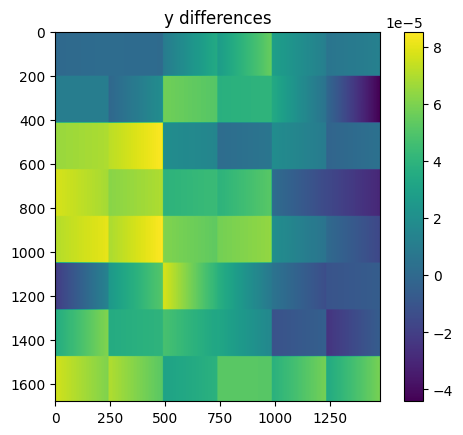

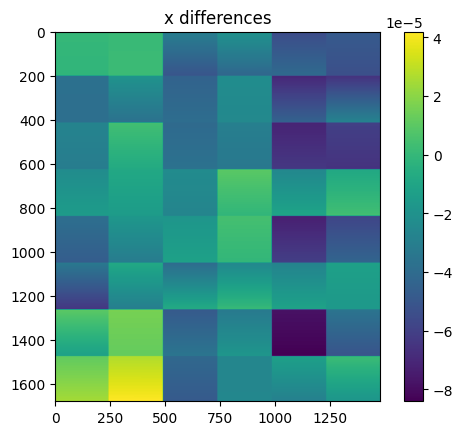

In [35]:
pl.figure()
pl.imshow(pixelPlot[:,:,0])
pl.colorbar()
pl.title('y differences')
pl.figure()
pl.title('x differences')
pl.imshow(pixelPlot[:,:,1])
pl.colorbar()


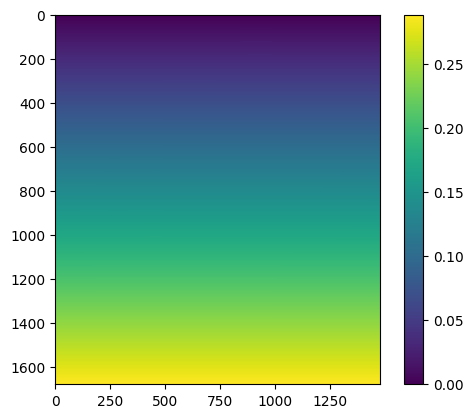

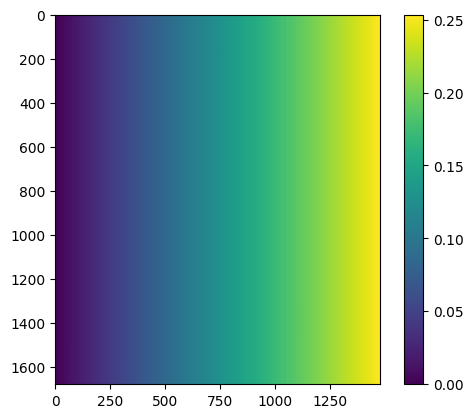

In [36]:
pl.figure()
pl.imshow(pilatusPixelCorners[:,:,0,1])
pl.colorbar()
pl.figure()
pl.imshow(pilatusPixelCorners[:,:,0,2])
pl.colorbar()

#### To use the correction in pyFAI I found I had to run through pyFAI-calib2 with the standard detector as normal, then after fitting, load the custom detector file (.h5), and refit the parameters. For some reason pyFAI couldn't automatically find the rings and really struggled to find a good initial fit when loading the custom detector file at first. 
#### It gave a ~10% improvement in rms on 3 images I tried, but with certain diffraction rings the impact was very visible.

In [42]:
#save detector for pyFAI
import pyFAI
detector = pyFAI.detector_factory('Pilatus2mcdte')
detector.set_pixel_corners(pilatusPixelCorners)
detector.save('pilatusPixelCorrections.h5')

In [39]:
help(detector.set_offset_files)

Help on method set_offset_files in module pyFAI.detectors._dectris:

set_offset_files(x_offset_file=None, y_offset_file=None) method of pyFAI.detectors._dectris.Pilatus2M instance



In [40]:
print(pilatusPixelCorners[0,0])
print(pilatusPixelCorners[1,1])

[[ 0.00000000e+00 -1.15223998e-04 -5.95598974e-05]
 [ 0.00000000e+00  5.67760020e-05 -5.95676443e-05]
 [ 0.00000000e+00  5.67837489e-05  1.12432356e-04]
 [ 0.00000000e+00 -1.15216251e-04  1.12440102e-04]]
[[0.00000000e+00 5.67837489e-05 1.12432356e-04]
 [0.00000000e+00 2.28783749e-04 1.12424609e-04]
 [0.00000000e+00 2.28791496e-04 2.84424608e-04]
 [0.00000000e+00 5.67914958e-05 2.84432355e-04]]


In [48]:
t = transformer()
index = 1
t.loadfiltered(flts[index])
print(flts[index])
c = t.colfile
c.sc[:] = ds[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.s_raw[:]
c.fc[:] = df[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.f_raw[:]
rerefineFile = os.path.split(flts[index])[1].replace('.flt','_s.par')
t.loadfileparameters(f'{fltdir}/{rerefineDir}/{rerefineFile}')
t.compute_tth_eta()
t.addcellpeaks()
t.parameterobj.varylist.append('wavelength')
t.fit()

pilatusSpatial\pos02_Si_dty_179_dtz_53.5_000_0001p.flt
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 81   Best = 4.795560   Worst = 4.795792                                            [1262.2020541997206, 250.03781461577907, 1161.799377574576, -0.0004705291074616748, 0.0060468052187684735, 0.2550964034410456]


In [49]:
t.fit_tolerance=0.005
for i in range(3):
    t.addcellpeaks() 
    t.fit()
    t.compute_tth_eta()
t.addcellpeaks() # wavelength is fitted

Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 34   Best = 4.795560   Worst = 4.795831                             [1262.2020541997206, 250.03781461577907, 1161.799377574576, -0.0004705291074616748, 0.0060468052187684735, 0.2550964034410456]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 34   Best = 4.795560   Worst = 4.795831                                 [1262.2020541997206, 250.03781461577907, 1161.799377574576, -0.0004705291074616748, 0.0060468052187684735, 0.2550964034410456]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 34   Best = 4.795560   Worst = 4.795831                                 [1262.2020541997206, 250.03781461577907, 1161.799377574576, -0.0004705291074616748, 0.0060468052187684735, 0.2550964034410456]


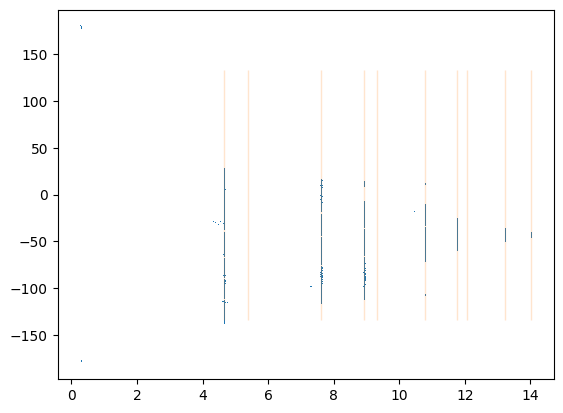

In [50]:
%matplotlib inline
pl.figure(dpi = 100)
etareplot = np.where(t.colfile.eta < 0, t.colfile.eta+180,t.colfile.eta-180)
pl.plot(t.colfile.tth,etareplot,",")
pl.plot(t.theorytth,np.zeros(len(t.theorytth)),"|",ms=180,alpha=0.2)

In [51]:
12.3984/t.parameterobj.parameters['wavelength']

48.602802049560644

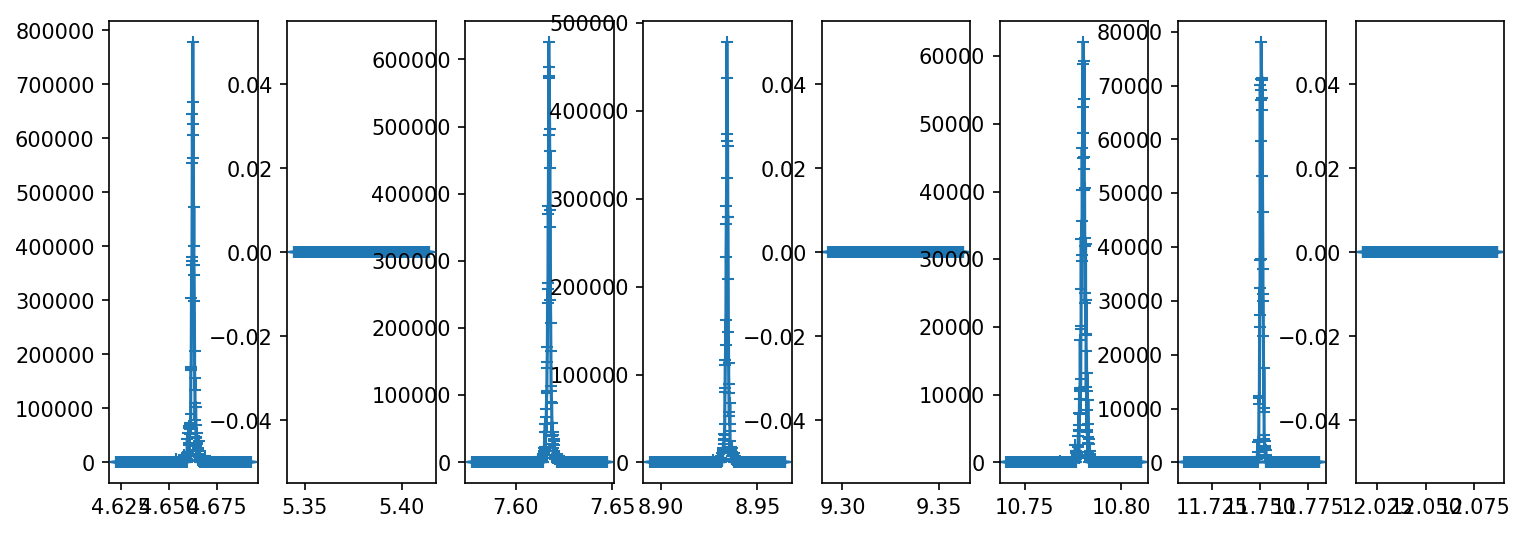

In [52]:
h,b = np.histogram(c.tth,weights=c.sum_intensity,bins=np.arange(0,c.tth.max(),0.0001))
pl.figure()
pl.plot(b[1:],h,'+-')
%matplotlib inline
fig,a=pl.subplots(1,8,figsize=(12,4),dpi = 150)
for i,tth in enumerate(t.theorytth[:8]):
    lo = np.searchsorted(b,tth-0.04)
    hi = np.searchsorted(b,tth+0.03)
    a[i].plot( b[lo:hi], h[lo:hi], "+-" )

In [53]:
c.parameters = t.parameterobj

In [54]:
c.updateGeometry()

C:\Users\kenneth1a\Anaconda3\envs\id11\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


tth   npks    rad_mean    rad_std    Median_abs_dev  Mean_abs_dev
4.66243  1513 1259.804 0.164 0.110 0.131
7.61723  1964 2058.205 0.167 0.111 0.134
8.93446  1951 2414.104 0.152 0.101 0.121
10.78035  1560 2912.877 0.245 0.170 0.199
11.75087  1004 3175.117 0.152 0.110 0.125
13.21297   441 3570.189 0.152 0.105 0.124
14.01837   190 3787.827 0.145 0.113 0.120


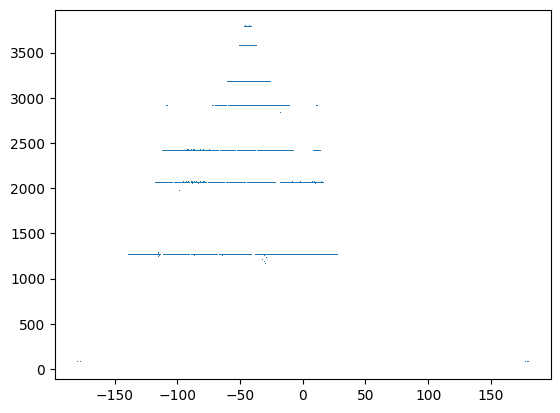

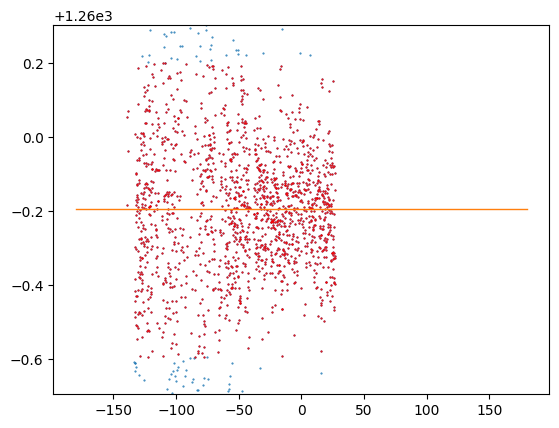

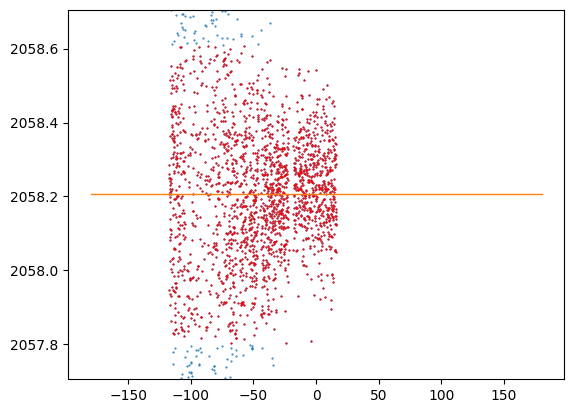

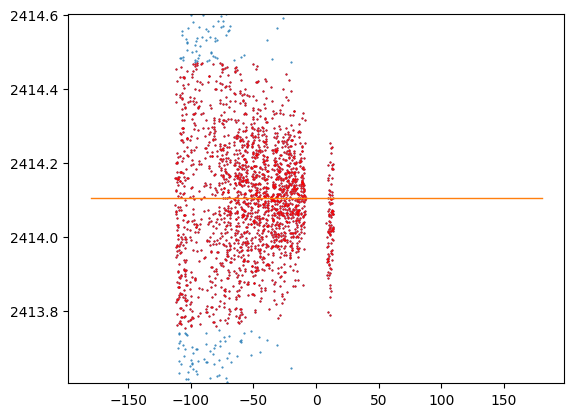

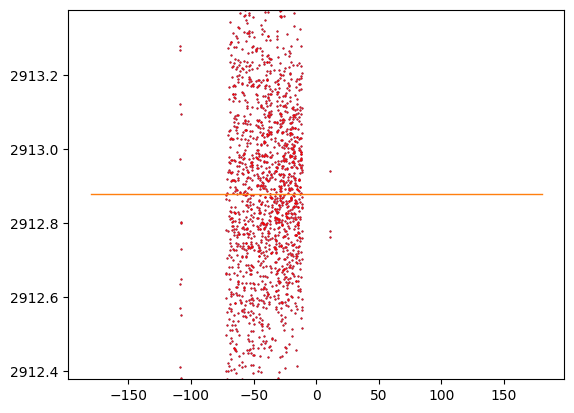

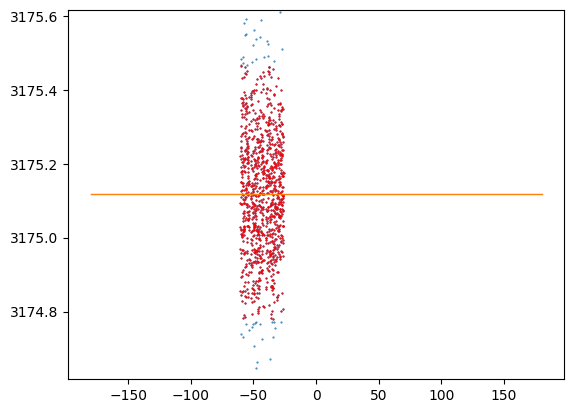

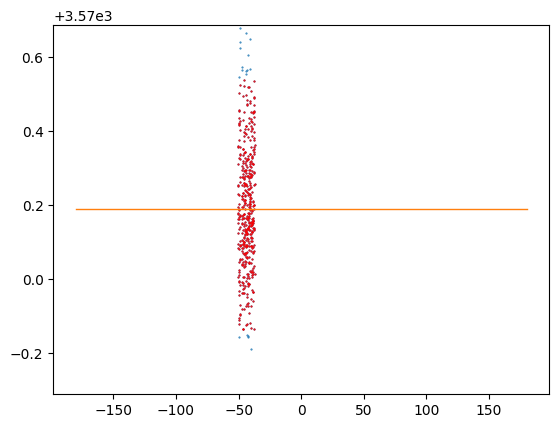

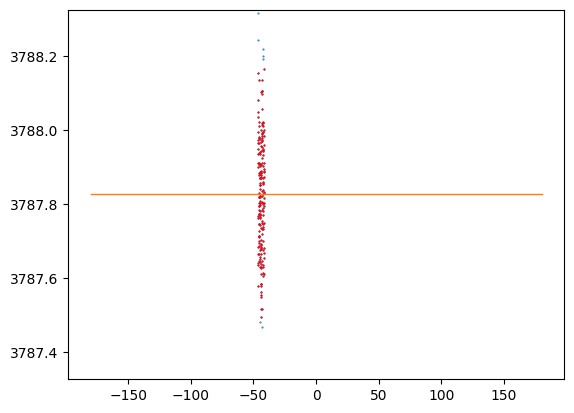

In [55]:
%matplotlib inline
c.titles
r = np.arctan2(np.sqrt(c.yl*c.yl+c.zl*c.zl), c.xl)*c.xl.mean()/0.075
pl.figure()
etareplot = np.where(c.eta < 0, c.eta + 180, c.eta - 180) 
pl.plot(etareplot,r,",")
rcalc = np.zeros(r.shape,np.float)
lines = ["tth   npks    rad_mean    rad_std    Median_abs_dev  Mean_abs_dev",]
for tth in t.theorytth:
    sel = np.abs(c.tth - tth)<0.005
    pks = r[sel]
    if sel.sum()==0:
        continue
    rc = pks.mean()
    mad = np.median(abs(r[sel] - rc))
    msel = np.abs( r - rc ) < mad * 3
    pks = r[msel]
    rc = r[msel].mean()
    pl.figure()
    etareplot = np.where(c.eta[sel] < 0, c.eta[sel] +180, c.eta[sel] - 180)
    etareplotm = np.where(c.eta[msel] < 0, c.eta[msel] +180, c.eta[msel] - 180)
    pl.plot( etareplot, r[sel], '.', ms=1 )
    pl.plot( etareplotm, r[msel], '.r', ms=1 )
    pl.plot( (-180, 180), [rc, rc], '-', lw=1 )
    pl.ylim(rc-0.5, rc+0.5)
    ad = abs(pks-pks.mean())
    lines.append("%.5f %5d %.3f %.3f %.3f %.3f"%(
        tth,msel.sum(),pks.mean(),pks.std(),np.median(ad),np.mean(ad)))
for line in lines:
    print(line)

In [46]:
print("Output created on %s"%(time.ctime()))
print("Total runtime %.3f /s"%(time.time()-start))

Output created on Fri Aug 26 09:59:43 2022
Total runtime 349.772 /s
